# Проект "Обучение с учителем: качество модели" на примере интернет-магазина "В один клик"

<i>Заказчик проекта:</i> Интернет магазин "В один клик".\
<i>Цель проекта:</i> работать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.\
<i>Описание проекта:</i> Отчет магазина за прошлый период показал, что активность покупателей начала снижаться. Возможный выход - удерживать активность постоянных клиентов с помощью персонализированных предложений. У компании есть небольшой отдел цифровых технологий.\
Руководитель отдела уже сформировал план решения задачи:
1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Нужно собрать данные по клиентам по следующим группам:
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.\
3. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
4. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
5. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
Руководство одобрило описание решения, и нам нужно его реализовать.

Прежде чем приступить к анализу данных, познакомимся с ними, исправим неточности в записях, заполним пропуски и проверим на дубликаты в записях. После выявим аномальные значения в числовых показателях и примем решение: стоит ли их оставить или удалить.

In [1]:
!pip install phik -q
!pip install shap -q
!pip install -Uq matplotlib

In [2]:
#Загрузим необходимые библиотеки:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import phik

from sklearn.model_selection import train_test_split

# загружаем класс pipeline:
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками:
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками:
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 

import warnings 
warnings.filterwarnings("ignore")

import shap

from sklearn.tree import plot_tree
from sklearn.datasets import make_classification

from sklearn.feature_selection import SelectKBest, f_classif

## Загрузка данных

Загрузим имеющиеся данные и познакомимся с ними.\
<i><b>market_file</b></i>\
Таблица содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
#выведим 1-ые 5 строк:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
market_file.shape

(1300, 13)

В market_file 1300 строк и 13 колонок.\
Описание данных:
- id — номер покупателя в корпоративной базе данных;
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

<b><i>market_money</i></b>\
Таблица содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [5]:
market_money = pd.read_csv('/datasets/market_money.csv')
#размер таблицы
print(market_money.shape)

market_money.head()

(3900, 3)


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


В market_money 3 колонки и 3900 строк.\
Описание данных:
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка
- Выручка — сумма выручки за период.

<b><i>Market_time</i></b>\
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [6]:
market_time = pd.read_csv('/datasets/market_time.csv')
print(market_time.shape)

market_time.head()

(2600, 3)


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [7]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Market_time содержит 3 колонки и 2600 строк.\
Обратим внимание на ошибку в написании признака "предыдцщий_месяц", исправим ее следующем шаге "Предобработка данных". Также напишем название столбца "минут" с заглавной буквы.\
Описание данных:
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

<b><i>Money</i></b>\
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.\
 При загрузке укажем параметр delimiter=";" в качестве разделителя между столбцами; а также параметр decimal="," в качестве разделителя десятичной части чисел.

In [8]:
money = pd.read_csv('/datasets/money.csv', delimiter=";", decimal=",")
print(money.shape)

money.head()

(1300, 2)


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Money содержит 2 столбца и 1300 строк.\
Описание данных:
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

## Предобработка данных

Приведем названия столбцов в датафреймах к единному виду.

In [9]:
market_time = market_time.rename(
    columns={'минут': 'Минут'}
)
market_time.columns

Index(['id', 'Период', 'Минут'], dtype='object')

In [10]:
market_file.columns = market_file.columns.str.replace(' ', '_')

market_file.columns

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

Исправим орфографическую ошибку в названии признака:

In [11]:
market_time['Период'] = market_time['Период'].replace({'предыдцщий_месяц': 'предыдущий месяц'})
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий месяц'], dtype=object)

Проверим на наличие пропущенных значений и дубликатов в датафреймах. При их наличии обработаем их.

In [12]:
#Проверка на наличие пропущенных значений:
market_file.isna().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [13]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [14]:
market_time.isna().sum()

id        0
Период    0
Минут     0
dtype: int64

In [15]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

Пропущенных значений ни в одной из таблиц нет. Проверим на наличие дубликатов:

In [16]:
print(f'Количество дубликатов в market_file:', market_file.duplicated().sum())
print(f'Количество дубликатов в market_money:', market_money.duplicated().sum())
print(f'Количество дубликатов в market_time:', market_time.duplicated().sum())
print(f'Количество дубликатов в money:', money.duplicated().sum())

Количество дубликатов в market_file: 0
Количество дубликатов в market_money: 0
Количество дубликатов в market_time: 0
Количество дубликатов в money: 0


Явных дубликатов в таблицах также нет.\
Выведим основную информацию по файлам и проверим корректность типов данных в них:

In [17]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [18]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [19]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   Минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [20]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Тип данных для всех показателей указан верный.\
Проверим файлы на неявные дубликаты:

In [21]:
#Уникальные значения нечисловых показателей в файле market_fail:
print(f'Уникальные значения "Покупательская_активность":', market_file['Покупательская_активность'].unique())
print(f'Уникальные значения "Тип_сервиса":', market_file['Тип_сервиса'].unique())
print(f'Уникальные значения "Разрешить_сообщать":', market_file['Разрешить_сообщать'].unique())
print(f'Уникальные значения "Популярная_категория":', market_file['Популярная_категория'].unique())

Уникальные значения "Покупательская_активность": ['Снизилась' 'Прежний уровень']
Уникальные значения "Тип_сервиса": ['премиум' 'стандартт' 'стандарт']
Уникальные значения "Разрешить_сообщать": ['да' 'нет']
Уникальные значения "Популярная_категория": ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


В показателе "Тип сервиса" присутствует неявный дубликат ("стандартт", "стандарт"), устраним его:

In [22]:
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace({'стандартт': 'стандарт'})
market_file['Тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

В других столбцах неявных дубликатов нет.

In [23]:
#Уникальные значения нечисловых показателей в файле market_money:
print(f'Уникальные значения "Период":', market_money['Период'].unique())

Уникальные значения "Период": ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [24]:
#Уникальные значения нечисловых показателей в файле market_time:
print(f'Уникальные значения "Период":', market_time['Период'].unique())

Уникальные значения "Период": ['текущий_месяц' 'предыдущий месяц']


In [25]:
#заменим "предыдущий месяц" на "предудыщий_месяц":
market_time['Период'] = market_time['Период'].replace({'предыдущий месяц': 'предыдущий_месяц'})
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Явные и неявные дубликаты устранены, тип данных проверен, можем приступать к исследовательскому анализу данных.

## Исследовательский анализ данных

Данные о клиентах можно разделить на четыре категории:
- Поведение на сайте;
- Продуктовое поведение;
- Финансовое поведение;
- Коммуникация с клиентом.

Проанализировав имеющуюся информацию мы будем лучше понимать, как удержать клиентов, а также увеличить их покупательскую активность.

Сперва проанализируем <b>поведение клиента на сайте</b>. Сюда входят следующие признаки:
- Время на сайте за предыдущий месяц;
- Время на сайте за текущий месяц;
- Число страниц за визит;
- Сбой сайта.

Информация о времени, проведенном на сайте хранится в файле market_time. Сгруппируем данные по периодам:

In [26]:
round(market_time.groupby('Период')['Минут'].mean(), 2)

Период
предыдущий_месяц    13.47
текущий_месяц       13.20
Name: Минут, dtype: float64

Итак, в среднее время посетителей, которые они провели на сайте в текущем месяце и предыдущем очень близко и составляет 13 минут.

In [27]:
print('Минимальное время, проведенное на сайте в предыдущем месяце:', \
      market_time.query('Период == "предыдущий_месяц"')['Минут'].min())
print('Максимальное время, проведенное на сайте в предыдущем месяце:', \
      market_time.query('Период == "предыдущий_месяц"')['Минут'].max())

print('Минимальное время, проведенное на сайте в текущем месяце:', \
      market_time.query('Период == "текущий_месяц"')['Минут'].min())
print('Максимальное время, проведенное на сайте в текущем месяце:', \
      market_time.query('Период == "текущий_месяц"')['Минут'].max())

Минимальное время, проведенное на сайте в предыдущем месяце: 5
Максимальное время, проведенное на сайте в предыдущем месяце: 23
Минимальное время, проведенное на сайте в текущем месяце: 4
Максимальное время, проведенное на сайте в текущем месяце: 23


В предыдущем месяце минимальное время, проведенное на сайте было 5 минут, в текущем месяце сократилось до 4 минут. Максимальное время совпадает и равно 23 минут.

Разделим сводную информацию на периоды и визуализируем ее на графике:

In [28]:
market_time_last_month = market_time.query('Период == "предыдущий_месяц"')
market_time_current_month = market_time.query('Период == "текущий_месяц"')

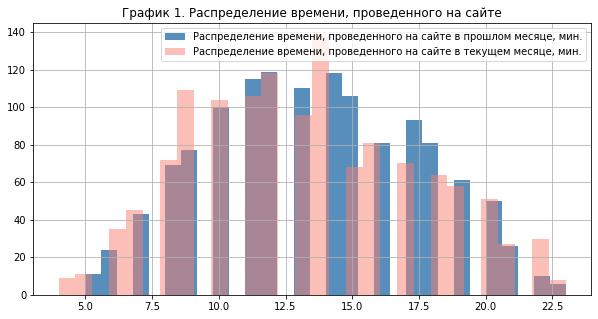

In [29]:
plt.figure(figsize=(10, 5))
plt.hist(market_time_last_month['Минут'],
         bins=30,
         label='Распределение времени, проведенного на сайте в прошлом месяце, мин.',
         alpha=0.9,
         color='steelblue'
        )
plt.hist(market_time_current_month['Минут'],
         bins=30,
         label='Распределение времени, проведенного на сайте в текущем месяце, мин.',
         alpha=0.5,
         color='salmon'
        )

plt.legend()
plt.title('График 1. Распределение времени, проведенного на сайте', fontsize=12)
plt.grid()
plt.show()

В текущем месяце количество клиентов, которые проводили на сайте свыше 13 минут сократилось.

Проанализируем среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

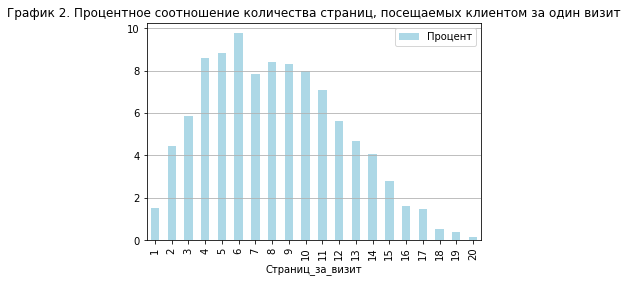

In [30]:
#сформируем сводную таблицу:
market_file_pivot_page = market_file.pivot_table(index='Страниц_за_визит', values='id', aggfunc='count')
#присвоим название столбцу:
market_file_pivot_page.columns= ['Количество']
#Найдем процентное соотношение:
market_file_pivot_page['Процент'] = market_file_pivot_page['Количество']\
                                          .apply(lambda x: x/market_file_pivot_page['Количество'].sum()*100)
#Визуализируем полученную информацию:
market_file_pivot_page.plot(y='Процент', kind='bar', color='lightblue', fontsize=10)
plt.title('График 2. Процентное соотношение количества страниц, посещаемых клиентом за один визит', fontsize=12)
plt.grid(axis='y')
plt.show()

In [31]:
market_file['Страниц_за_визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64

Среднее арифметическое значение количества просмотренных страниц за визит совпадает с медианным и равно 8 страниц.
1,5% покупателей просматривают только одну страницу. 27% - просматривают 4-6 страниц за визит. 18-20 страниц сайта просматривают лишь 1% посетителей.

Изучим информацию о количестве сбоев, которые коснулись покупателей во время посещения сайта.


In [32]:
market_file['Ошибка_сервиса'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64

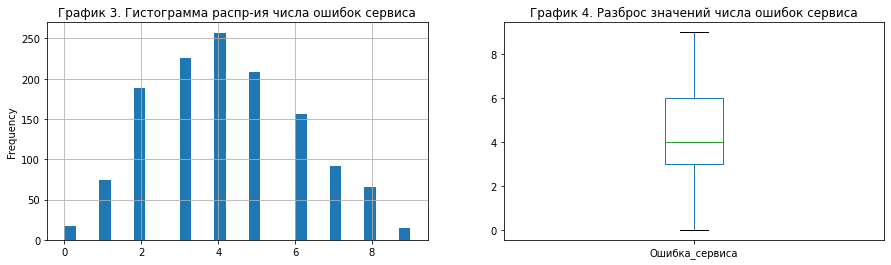

In [33]:
#гистограмма частотности распределения и "ящик с усами" для "Ошибка_сервиса":
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
market_file['Ошибка_сервиса'].plot(kind='hist', bins=30, ax=axes[0], grid=True)
axes[0].set_title("График 3. Гистограмма распр-ия числа ошибок сервиса")
market_file['Ошибка_сервиса'].plot(kind='box', ax=axes[1])
axes[1].set_title("График 4. Разброс значений числа ошибок сервиса")
plt.show()

Гистограмма похожа на нормальное распределение со смещением влево. Среднее арифметическое совпадает с медианным значением и равно 4 ошибкам. Клиенты сталкивались с ошибками сервиса от 0 до 9 раз.

<b>Продуктовое поведение</b> клиента характеризуют показатели:
- Популярная категория товара;
- Среднее число просматриваемых категорий продуктов за визит;
- Число неоплаченных продуктов в корзине за последние 3 месяца;
- Доля акционных покупок.

Выясним, какая категория товаров является самой популярной среди клиентов магазина:


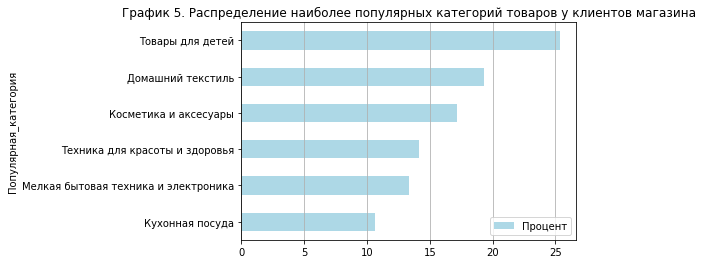

In [34]:
#Создадим сводную таблицу по показателю "Популярная_категория":
market_file_popular_category = market_file.pivot_table(index='Популярная_категория', values='id', aggfunc='count')
#Присвоим название столбцу:
market_file_popular_category.columns = ['Количество']
#Рассчитаем процентное соотношение:
market_file_popular_category['Процент'] = market_file_popular_category['Количество']\
                                          .apply(lambda x: x/market_file_popular_category['Количество'].sum()*100)
#Отсортируем данные по убыванию:
market_file_popular_category = market_file_popular_category.sort_values(by='Процент')
#Визуализируем полученную информацию:
market_file_popular_category.plot(y='Процент', kind='barh', color='lightblue', fontsize=10)
plt.title('График 5. Распределение наиболее популярных категорий товаров у клиентов магазина', fontsize=12)
plt.grid(axis='x')
plt.show()

Согласно графику 5, более 25% клиентов чаще покупают Товары для детей. На 2-м месте - Домашний текстиль (19%). Кухонная посуда - наименее популярная категория товаров, ее покупают меньше 11% посетителей.

Сколько в среднем покупатель просмотрел категорий товаров за визит в течение последнего месяца?


In [35]:
market_file['Средний_просмотр_категорий_за_визит'].describe()

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

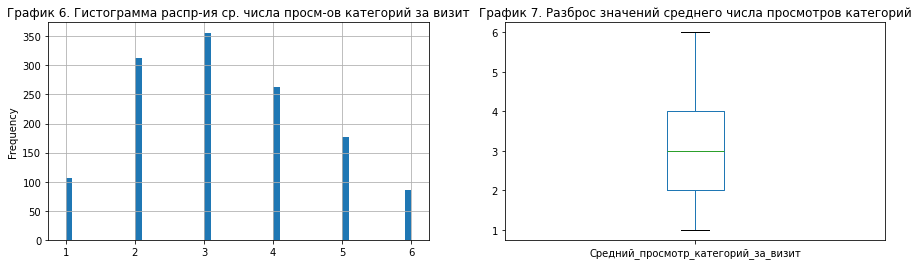

In [36]:
#гистограмма частотности распределения и "ящик с усами" для "Средний_просмотр_категорий_за_визит":
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
market_file['Средний_просмотр_категорий_за_визит'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 6. Гистограмма распр-ия ср. числа просм-ов категорий за визит")
market_file['Средний_просмотр_категорий_за_визит'].plot(kind='box', ax=axes[1])
axes[1].set_title("График 7. Разброс значений среднего числа просмотров категорий")
plt.show()


Итак, покупатели интернет-магазина в течение последнего месяца за один визит просматривали от 1 до 6 категорий товаров. Медианное значение 3.

Также у нас есть информация о количестве неоплаченных товаров в корзине покупателя за последние 3 месяца. Визуализируем данные:

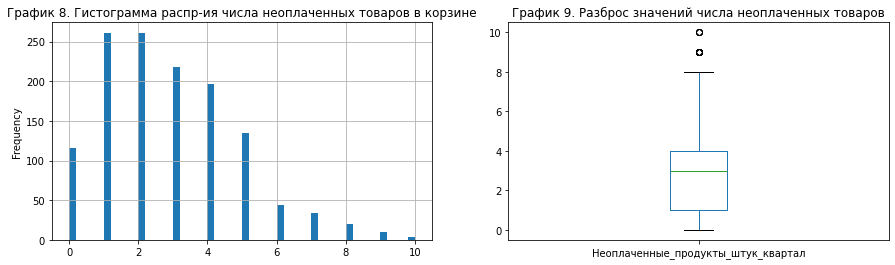

In [37]:
#гистограмма частотности распределения и "ящик с усами" для "Неоплаченные_продукты_штук_квартал":
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
market_file['Неоплаченные_продукты_штук_квартал'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 8. Гистограмма распр-ия числа неоплаченных товаров в корзине")
market_file['Неоплаченные_продукты_штук_квартал'].plot(kind='box', ax=axes[1])
axes[1].set_title("График 9. Разброс значений числа неоплаченных товаров")
plt.show()

In [38]:
market_file['Неоплаченные_продукты_штук_квартал'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

Число неоплаченных товаров в корзине покупателей измеряется от 0 до 10. Согласно методу boxplot() нормальными значениями являются от 0 до 8. Медианное значение при этом равно 3. Наиболее частое значение - от 0 до 5 товаров.\
На графике 9 видим выбросы - 9 и 10 неоплаченных товаров.

Проанализиуем среднемесячную долю покупок по акции от общего числа покупок за последние 6 месяцев:

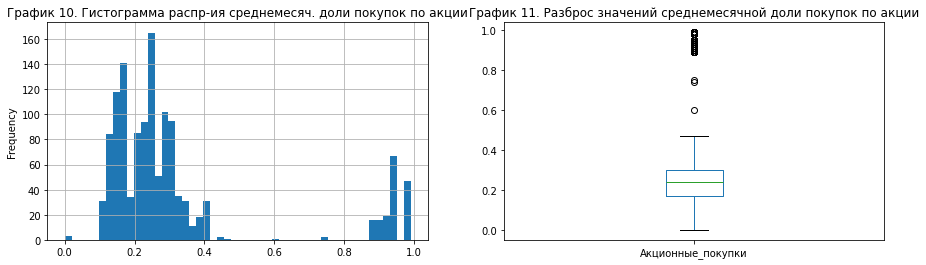

In [39]:
#гистограмма частотности распределения и "ящик с усами" для "Акционные_покупки":
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
market_file['Акционные_покупки'].plot(kind='hist', bins=50, grid=True, ax=axes[0])
axes[0].set_title("График 10. Гистограмма распр-ия среднемесяч. доли покупок по акции")
market_file['Акционные_покупки'].plot(kind='box', ax=axes[1])
axes[1].set_title("График 11. Разброс значений среднемесячной доли покупок по акции")
plt.show()

In [40]:
market_file['Акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

На гистограмме распределения наблюдаем два "всплеска", при чем второй всплеск ближе к 100% метод boxplot оценил, как аномальный. Нормальными значениями для данного показателя лежат в диапазоне от 0 до 50%.
Согласно медианному значению, 24% покупок клиенты совершают по акции. Среднее арифметическое составиляет 32%, на него повлияли покупатели, которые совершают 90-100% покупок по акциям. Стандартное отклонение - 25%, что также указывает на сильный разброс значений.

Следующая категория - <b>Финансовое поведение</b> клиента. Характеризуется такими показателями, как:
- Выручка в текущем месяце;
- Выручка в предыдущем месяце;
- Выручка в предпредыдущем месяце.\
Информация хранится в файле market_money и отображает, сколько покупатель потратил всего денежных средств за период взаимодействия с сайтом. Иными словами, какую выручку магазин получает с клиента.

In [41]:
market_money.groupby('Период')['Выручка'].sum()

Период
предыдущий_месяц       6417996.5
препредыдущий_месяц    6272769.0
текущий_месяц          6909449.1
Name: Выручка, dtype: float64

В файле market_money хранится информация о сумме выручки за последние 3 месяца. Согласно сгруппированным данным выручка магазина растет с каждым месяцем. За рассматриваемый период магазин заработал 19,6 млн.руб.

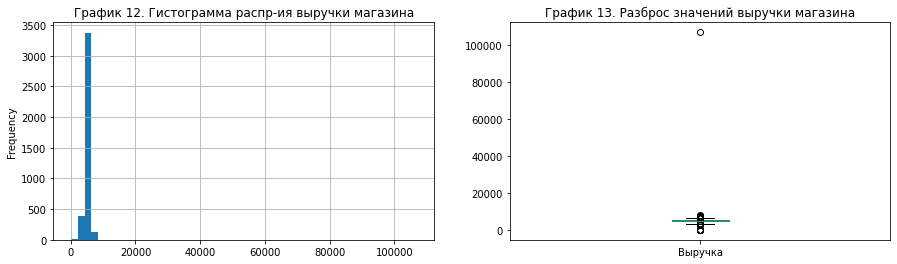

In [42]:
#гистограмма частотности распределения и "ящик с усами" для "Выручка":
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
market_money['Выручка'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 12. Гистограмма распр-ия выручки магазина")
market_money['Выручка'].plot(kind='box', ax=axes[1])
axes[1].set_title("График 13. Разброс значений выручки магазина")
plt.show()

В выборке присутствует один крупный выброс в размере 106862,2 руб. В связи с чем гистограмма распределения оказалась не информативна. Также на графике 13 мы видим, что присустуют еще аномальные выбросы, но пока мы их также сложно оценить. Построим оба графика повторно, исключив из рассмотрения сумму 106 тыс.руб. Удалять аномальное значение пока не будем.


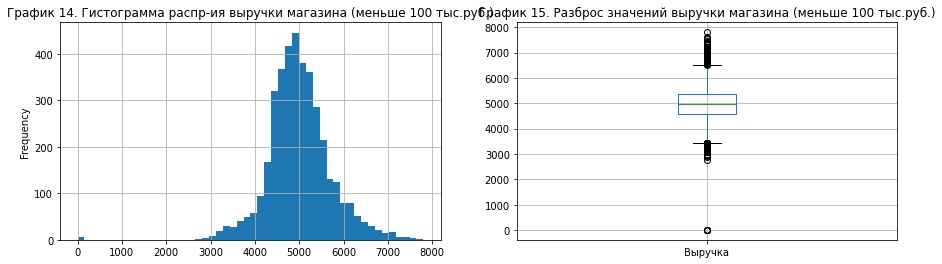

In [43]:
market_money_2 = market_money.query('Выручка < 100000')
#гистограмма частотности распределения и "ящик с усами" для выручки меньше 100 тыс.руб.:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
market_money_2['Выручка'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 14. Гистограмма распр-ия выручки магазина (меньше 100 тыс.руб.)")
market_money_2['Выручка'].plot(kind='box', ax=axes[1], grid=True)
axes[1].set_title("График 15. Разброс значений выручки магазина (меньше 100 тыс.руб.)")
plt.show()

In [44]:
market_money_2['Выручка'].describe()

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: Выручка, dtype: float64

После исключения выручки от клиента свыше 100 тыс.руб., гистограмма распределения и "ящик с усами" стали более информативными.
Гистограмма похожа на нормальное распределение с центром "колока" в 5 тыс.руб. Медиана совпадает со средним арифметическим (5 тыс.руб.), стандартное отклонение составляет 707 руб. На графиках видим, что есть несколько выбросов, равные 0 руб. А также метод boxplot() расценил суммы ниже 3,5 тыс.руб. и выше 6,5 тыс.руб. также аномальными выбросами.

Проанализируем, как менялось распределение выручки по периодам:

In [45]:
#Выделим в отдельные датафреймы три периода:
market_money_current = market_money_2.query('Период == "текущий_месяц"')
market_money_last = market_money_2.query('Период == "предыдущий_месяц"')
market_money_2_month_ago = market_money_2.query('Период == "препредыдущий_месяц"')

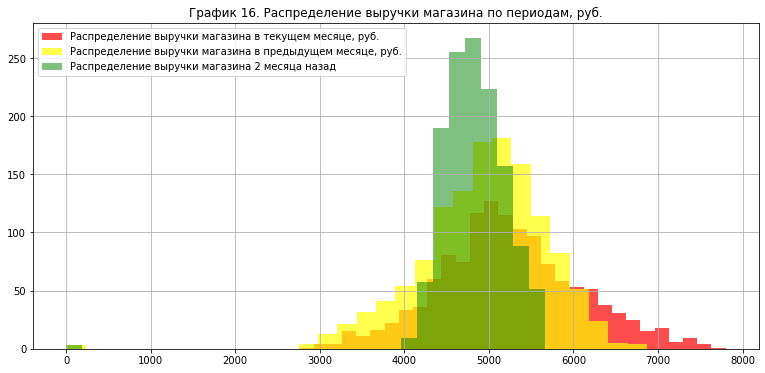

In [46]:
plt.figure(figsize=(13, 6))

plt.hist(market_money_current['Выручка'],
         bins=30,
        label='Распределение выручки магазина в текущем месяце, руб.',
         alpha=0.7,
         color='red'
        )
plt.hist(market_money_last['Выручка'],
         bins=30,
         label='Распределение выручки магазина в предыдущем месяце, руб.',
         alpha=0.7,
         color='yellow'
        )
plt.hist(market_money_2_month_ago['Выручка'],
         bins=30,
         label='Распределение выручки магазина 2 месяца назад',
         alpha=0.5,
         color='green'
        )
plt.legend()
plt.title('График 16. Распределение выручки магазина по периодам, руб.', fontsize=12)
plt.grid()
plt.show()

На выше представленном графике мы видим, как менялось распределение выручки магазина от клиентов. 2 месяца назад покупатели в среднем тратили на сайте 4,8 тыс. руб. в месяц, при этом диапазон значений лежит от 4 тыс. руб. до 5,7 тыс. руб.\
В прошлом же месяце покупатели потратили на сайте от 2,8 тыс. руб. до 6,9 тыс. руб., при этом средняя сумма выручки от клиента увеличилась и составила 5 тыс.руб.\
В текущем месяце покупатели в среднем стали тратить 5,2 тыс. руб. в месяц, но при этом диапазон значений выручки увеличился. Клиенты потратили в текущем месяце от 2,7 тыс. руб. до 7,8 тыс. руб.

У нас осталась последняя категория признаков для изучения - <b>Коммуникация с клиентом</b>.\
К данной категории относятся следующие признаки:
- Тип сервиса;
- Разрешение на сообщение;
- Маркетинг 6 мес.;
- Маркетинг текущего месяца;
- Длительность истории с клиентом.

Визуализируем также информацию о Покупательской активности.

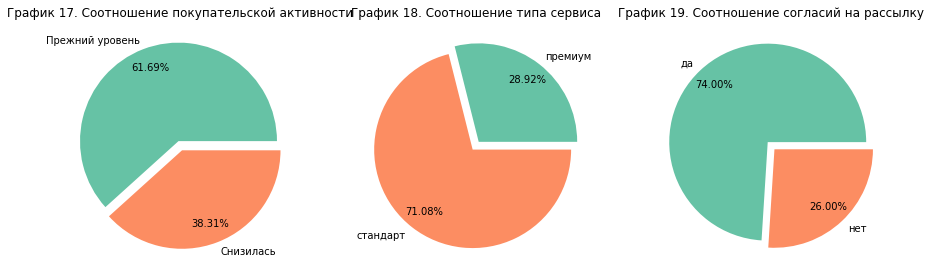

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15,8))

(
    market_file
    .pivot_table(index='Покупательская_активность', values='id', aggfunc='count')
    .plot(kind='pie',
          autopct='%1.2f%%',
          textprops={'fontsize':10}, 
          colors=sns.color_palette('Set2'),
          legend=False,
          subplots=True,
          ax=ax1,
          explode=[0.05, 0.05], #добавим "пробел" между секторами
          pctdistance=0.80, #переместим значения внутрь секторов
          fontsize=10,
          ylabel=''
         )
)
ax1.set_title("График 17. Соотношение покупательской активности", fontsize=12)

(
    market_file
    .pivot_table(index='Тип_сервиса', values='id', aggfunc='count')
    .plot(kind='pie',
          autopct='%1.2f%%',
          textprops={'fontsize':10}, 
          colors=sns.color_palette('Set2'),
          legend=False,
          subplots=True,
          ax=ax2,
          explode=[0.05, 0.05], #добавим "пробел" между секторами
          pctdistance=0.80, #переместим значения внутрь секторов
          fontsize=10,
          ylabel=''
         )
)
ax2.set_title("График 18. Соотношение типа сервиса", fontsize=12)

(
    market_file
    .pivot_table(index='Разрешить_сообщать', values='id', aggfunc='count')
    .plot(kind='pie',
          autopct='%1.2f%%',
          textprops={'fontsize':10}, 
          colors=sns.color_palette('Set2'),
          legend=False,
          subplots=True,
          ax=ax3,
          explode=[0.05, 0.05], #добавим "пробел" между секторами
          pctdistance=0.80, #переместим значения внутрь секторов
          fontsize=10,
          ylabel=''
         )
)
ax3.set_title("График 19. Соотношение согласий на рассылку", fontsize=12);


Напомню, в файле market_file хранится информация о 1300 клиентах. У 38% клиентов уровень покупательской активности снизился.\
71% покупателей имеют стандартный тип сервиса и 74% согласны получать дополнительный предложения о товарах.

Визуализируем информацию о среднемесячном объеме маркетинговых коммуникаций компании. Т.е. какое число рассылок, звонков, показов рекламы и прочего в среднем приходилось на клиента в месяц за последнее полугодие. 

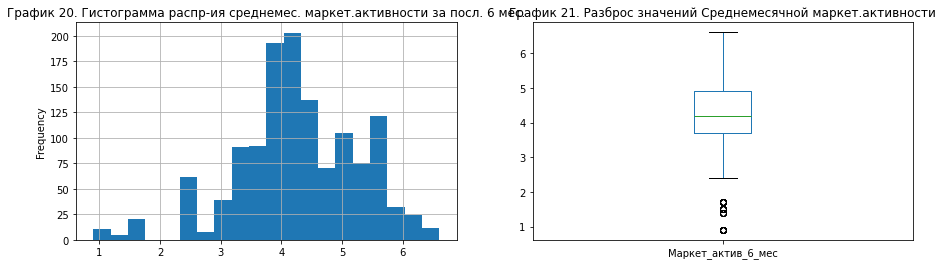

In [48]:
#гистограмма частотности распределения и "ящик с усами" для "Маркет_актив_6_мес":
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
market_file['Маркет_актив_6_мес'].plot(kind='hist', bins=20, grid=True, ax=axes[0])
axes[0].set_title("График 20. Гистограмма распр-ия среднемес. маркет.активности за посл. 6 мес.")
market_file['Маркет_актив_6_мес'].plot(kind='box', ax=axes[1])
axes[1].set_title("График 21. Разброс значений Среднемесячной маркет.активности")
plt.show()

In [49]:
market_file['Маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

За последние 6 месяцев клиенты в среднем взаимодействовали от 1 до 6,6 раз в месяц. При чем метод boxplot показал, что 1 и 2 предложения в месяц считает нетипичным, аномальным для данной выборки.\
В среднем клиенты получаели 4 предложения о товарах в месяц. При чем, среднее арифметическое и медианный показатель совпадают, что говорит о не сильном разбросе данных.

Проанализируем Маркетингувую активность за текущий месяц:

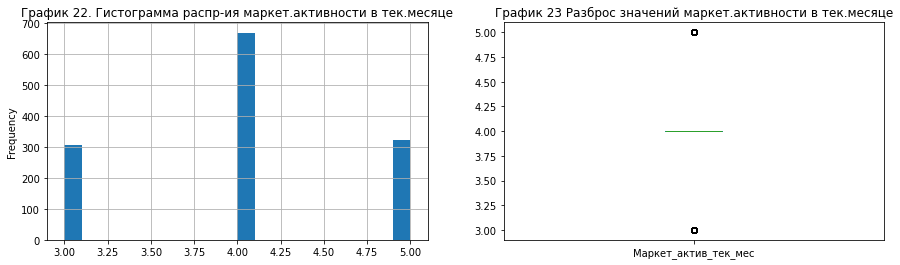

In [50]:
#гистограмма частотности распределения и "ящик с усами" для "Маркет_актив_тек_мес":
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
market_file['Маркет_актив_тек_мес'].plot(kind='hist', bins=20, grid=True, ax=axes[0])
axes[0].set_title("График 22. Гистограмма распр-ия маркет.активности в тек.месяце")
market_file['Маркет_актив_тек_мес'].plot(kind='box', ax=axes[1])
axes[1].set_title("График 23 Разброс значений маркет.активности в тек.месяце")
plt.show()

In [51]:
market_file['Маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64

In [52]:
print(f'Количество клиентов, получивших 3 дополнительных предложения:', 
      market_file.query('Маркет_актив_тек_мес == 3')['id'].count())
print(f'Количество клиентов, получивших 5 дополнительных предложения:', 
      market_file.query('Маркет_актив_тек_мес == 5')['id'].count())

Количество клиентов, получивших 3 дополнительных предложения: 308
Количество клиентов, получивших 5 дополнительных предложения: 323


В текущем месяце клиенты в среднем получили 4 дополнительных предложения о товарах. Метод boxplot посчитал количество маркетинговых рассылок в размере 3 и 5 штук аномальными выбросами. В тоже время, в сумме 631 клиент получили рассылки в таком объеме, или 48,5% всех клиентов. Что является почти половиной выборки, в следвие чего мы не можем согласиться, что это аномальные выбросы.\
Визуализируем информацию о длительности пользования клиентов интернет-магазином "В один клик":

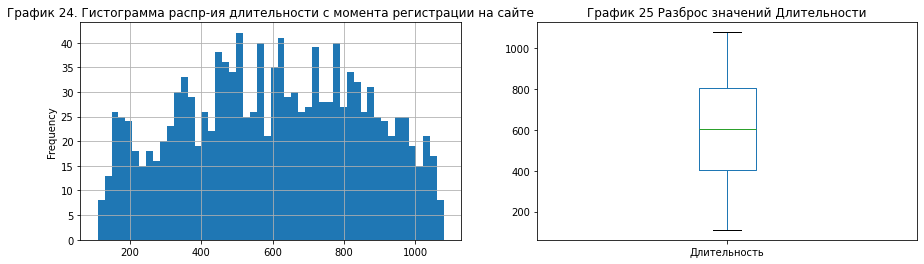

In [53]:
#гистограмма частотности распределения и "ящик с усами" для "Длительность":
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
market_file['Длительность'].plot(kind='hist', bins=50, grid=True, ax=axes[0])
axes[0].set_title("График 24. Гистограмма распр-ия длительности с момента регистрации на сайте")
market_file['Длительность'].plot(kind='box', ax=axes[1])
axes[1].set_title("График 25 Разброс значений Длительности")
plt.show()

In [54]:
market_file['Длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

В среднем клиенты интернет-магазина зарегестрированы на сайте 601 день. Последний клиент зарегистрированн 110 дней назад, а самый первый - 1079 дней назад, т.е. чуть меньше трех лет.

Осталась последняя таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Проанализируем информацию:

In [55]:
money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

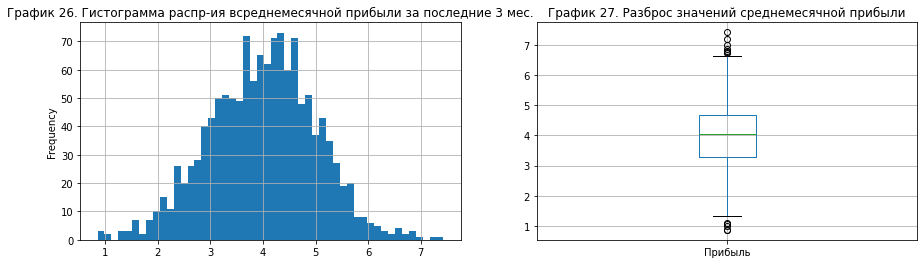

In [56]:
#гистограмма частотности распределения и "ящик с усами" для "Прибыль":
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
money['Прибыль'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 26. Гистограмма распр-ия всреднемесячной прибыли за последние 3 мес.")
money['Прибыль'].plot(kind='box', ax=axes[1], grid=True)
axes[1].set_title("График 27. Разброс значений среднемесячной прибыли")
plt.show()

Гистограмма напоминает нормальное распределение со смещением вправо. Метод boxplot() показывает, что нормальными значениями признака являются значения в диапазоне [1,2; 6,5]. Значения, не входившие в этот диапазон являются аномальными выбросами.
В среднем прибыль интернет-магазина от одного покупателя составляет 4 руб. Стандартное отклонение равно 1, что говорит о довольно существенном разбросе данных.

Отберем клиентов с покупательской активностью не менее 3-х месяцев. \
Пойдем от обратного, и найдем клиентов, чья выручка равна 0 в каком-либо из периодов:

In [57]:
market_money.query('Выручка == 0')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Итак, покупательская активность клиентов, чьи id: 215348, 215357, 215359, меньше трех месяцев. На следующем шаге исключим их из анализа.

In [58]:
market_money_2 = market_money.query('id !=[215348, 215357, 215359]')

## Объединение таблиц

Объединять таблицы будем путем добавления к файлу market_file столбцов из файлов market_money_2, market_time. При этом разделяя информацию по периодам.\
Видоизменим таблицы market_money_2, market_time: развернем их погоризонтали.

In [59]:
market_money_pivot = market_money_2.pivot_table(index='id', columns='Период', values='Выручка')
#добавим индекс в таблицу
market_money_pivot = market_money_pivot.reset_index()
#переименуем столбцы:
market_money_pivot = market_money_pivot.rename(
    columns={'предыдущий_месяц': 'Выручка_предыдущий мес.',
            'препредыдущий_месяц': 'Выручка_препредыдущий_мес.',
            'текущий_месяц': 'Выручка_текущий_мес.'}
)
market_money_pivot.head()

Период,id,Выручка_предыдущий мес.,Выручка_препредыдущий_мес.,Выручка_текущий_мес.
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


В файле market_time хранится информация только за текущий и предыдущий месяц.

In [60]:
market_time_pivot = market_time.pivot_table(index='id', columns='Период', values='Минут')
#добавим индекс в таблицу
market_time_pivot = market_time_pivot.reset_index()
#переименуем столбцы:
market_time_pivot = market_time_pivot.rename(
    columns={'предыдущий_месяц': 'Минут_предыдущий_мес.',
            'текущий_месяц': 'Минут_текущий_мес.'}
)
market_time_pivot.head()

Период,id,Минут_предыдущий_мес.,Минут_текущий_мес.
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


С помощью метода merge() объединим имеющуюся информацию в один файл:

In [61]:
#Внесем информацию о выручке:
market = market_file.merge(market_money_pivot, on='id', how='left')

#Внесем информацию о времени:
market = market.merge(market_time_pivot, on='id', how='left')

#Выведим первые 5 строк получившейся таблицы:
market.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий мес.,Выручка_препредыдущий_мес.,Выручка_текущий_мес.,Минут_предыдущий_мес.,Минут_текущий_мес.
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [62]:
market.shape

(1300, 18)

Во время исследовательского анализа данных мы обнаружили аномальный выброс выручки в размере 106 тыс.руб., удалим информацию об этом клиенте из обобщенной таблицы. Также удалим из таблицы клиентов, чья покупательская активность меньше 3 месяцев.

In [63]:
market = market.query('id != [215380, 215348, 215357, 215359]')
market.shape

(1296, 18)

Объединение таблиц прошло корректно.

## Корреляционный анализ

Изучим взаимосвязь между признаками в количественном выражении. Для этого рассчитаем коэффициент корреляции Фи, который находит взаимосвязь между категориальными, порядковыми и интервальными признаками. Кроме того, Phik подходит для случаев, когда данные распределены не нормально. Чем ближе его значение по модулю к 1, тем сильнее связь.
Для простоты работы и восприятия, построим тепловую карту с помощью метода heatmap() из библиотеки seaborn.\
Матрицу корреляции будем строить отдельно для группы лиц, чья покупательская активность снизилась и осталась на прежнем уровне.

In [64]:
#Уберем из корреляционного анализа id:
market_no_id=market.drop('id', axis=1)

#DataFrame для клиентов, чья покупательская активность снизилась и осталась прежней:
market_no_id_1 = market_no_id.query('Покупательская_активность == "Снизилась"')
market_no_id_2 = market_no_id.query('Покупательская_активность == "Прежний уровень"')

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий мес.', 'Выручка_препредыдущий_мес.', 'Выручка_текущий_мес.', 'Минут_предыдущий_мес.', 'Минут_текущий_мес.']


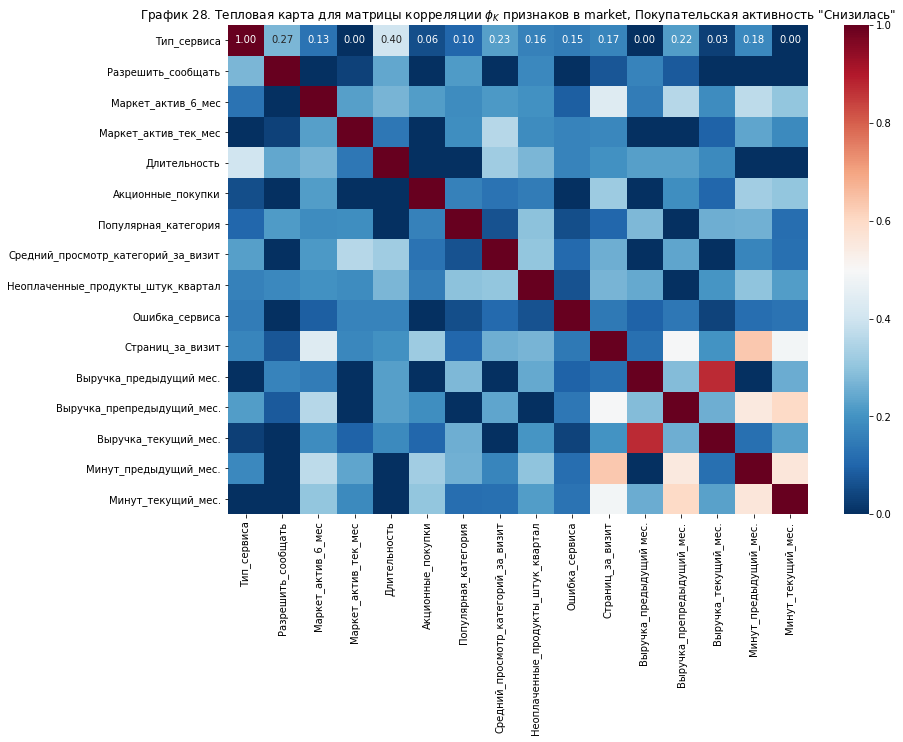

In [65]:
plt.subplots(figsize=(13, 9))
sns.heatmap(market_no_id_1.phik_matrix(), annot=True, fmt='.2f', cmap='RdBu_r')
plt.title('График 28. Тепловая карта для матрицы корреляции $\phi_K$ признаков в market, Покупательская активность "Снизилась"', fontsize=12);

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий мес.', 'Выручка_препредыдущий_мес.', 'Выручка_текущий_мес.', 'Минут_предыдущий_мес.', 'Минут_текущий_мес.']


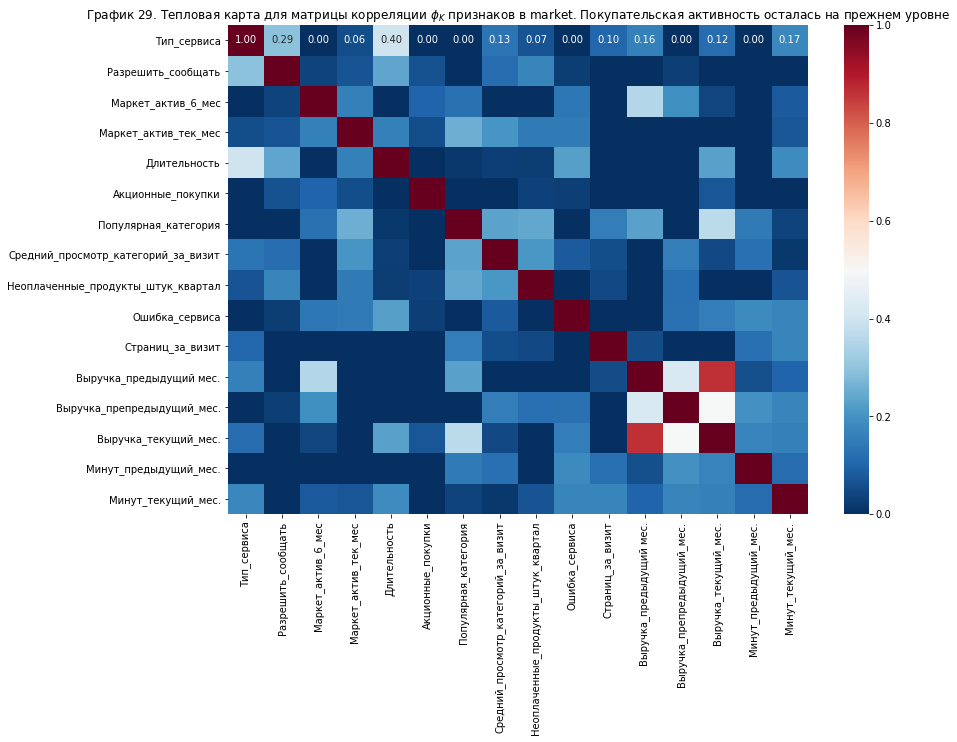

In [66]:
plt.subplots(figsize=(13, 9))
sns.heatmap(market_no_id_2.phik_matrix(), annot=True, fmt='.2f', cmap='RdBu_r')
plt.title('График 29. Тепловая карта для матрицы корреляции $\phi_K$ признаков в market. Покупательская активность осталась на прежнем уровне', fontsize=12);

На графиках 28, 29 отображены матрицы корреляций для признаков, для клиентов, сгруппированных по признакую "Покупательская активность" снизилась или осталась на прежнем уровне.\
На обоих графиках мы видим сильную корреляцию между признаками "Выручка в предыдущем месяце" и "Выручка в текущем месяце", равную 0,87. Но все же говорить о мультиколлинеарности признаков не можем, коэффициент ниже 0,9.

Построим матрицу корреляции для всех признаков:

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий мес.', 'Выручка_препредыдущий_мес.', 'Выручка_текущий_мес.', 'Минут_предыдущий_мес.', 'Минут_текущий_мес.']


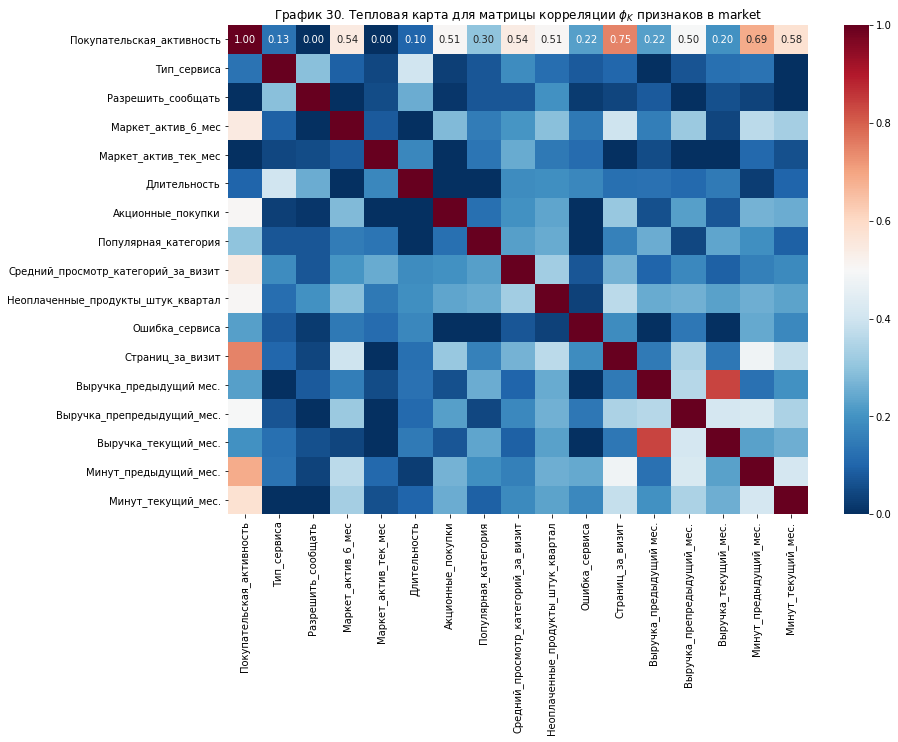

In [67]:
plt.subplots(figsize=(13, 9))
sns.heatmap(market_no_id.phik_matrix(), annot=True, fmt='.2f', cmap='RdBu_r')
plt.title('График 30. Тепловая карта для матрицы корреляции $\phi_K$ признаков в market', fontsize=12);

Как видно, из тепловой карты, согласно шкале Чеддока, у целевого признака "Покупательская активность" высокая линейная взаимосвязь с показателем "Страниц за визит" (0,75). С показателями "Минут_предыдущий_мес." (0,69) и "Минут_текущий_мес" (0,58), "Маркет_актив_6_мес" (0,54), "Средний_просмотр_категорий_за_визит" (0,54), "Акционные_покупки" (0,51), "Неоплаченные_продукты_штук_квартал" (0,51) заметная взаимосвязь.\
Мультиколлинеарности между признаками нет.

## Использование пайплайнов

С помощью пайплайна переберем варинаты масштабирования, модели и их гиперпараметры, и выберем лучшую комбинацию. 

Добавим столбец "Покупательская_активность_тип". Присвоим 1, если покупательская активность "Снизилась" и 0 в ином случае.

In [68]:
market['Покупательская_активность_тип'] = market.apply(lambda row: 1  if row['Покупательская_активность'] == 'Снизилась' else 0, axis=1)


In [69]:
#Преобразуем столбец 'id' в индекс:
market = market.set_index('id')
market.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий мес.,Выручка_препредыдущий_мес.,Выручка_текущий_мес.,Минут_предыдущий_мес.,Минут_текущий_мес.,Покупательская_активность_тип
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,1
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,1
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,1
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,1


In [70]:
#Разделим выборку на тренировочную и тестовую:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    market.drop(['Покупательская_активность', 'Покупательская_активность_тип'], axis=1),
    market['Покупательская_активность_тип'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = market['Покупательская_активность_тип']
)

X_train.shape, X_test.shape

((972, 16), (324, 16))

Целевой признак - "Покупательская_активность_тип".\
Три признака - "Разрешить_сообщать" и "Популярная_категория", - нужно кодировать с помощью OneHotEncoder.\
Признак "Тип_сервиса" нужно кодировать с помощью OrdinalEncoder.\
Оставшиеся признаки необходимо масштабировать.

In [71]:
#Создаем списки с названиями признаков:
ohe_columns = ['Разрешить_сообщать', 'Популярная_категория']
ord_columns = ['Тип_сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', \
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит',\
              'Выручка_текущий_мес.', 'Выручка_предыдущий мес.', 'Выручка_препредыдущий_мес.', 'Минут_текущий_мес.', 'Минут_предыдущий_мес.']

In [72]:
# создаем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

In [73]:
# создаем пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [74]:
# создаем общий пайплайн для подготовки данных:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [75]:
#создаем итоговый пайплайн:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    #словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    #словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    #словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
        random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1',
            C=1
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    #словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'poly',
            probability=True
        )],
        'models__degree': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

С помощью автоматизированного поиска GridSearchCV() переберем все варианции моделей и гиперпараметров и найдем ту, которая дает наилучший результат. GridSearchCV() занимает времени больше остальных методов, но другие не могут перебрать все вариации комбинаций без исключения.\
В качестве метрики выберем roc-auc. Она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения. Метрика roc-auc дает самую общую оценку итогов работы модели.\
Так как данные у нас не сбалансированы (соотношение показателя целевого признака соотносится как 62% на 38% "Прежний уровень" и "Снизилась" соответственно), мы не можем применить в данном случае метрику accuracy.

In [76]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

In [77]:
grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                   

С помощью созданного пайплайна мы определили, что модель LogisticRegression с гиперпараметрами C=1, penalty='l1', solver='liblinear и random_state=42  дает наилучший результат. Метрика ROC-AUC = 0.898, что является хорошим результатом.

Проверим работу модели на тестовой выборке:

In [78]:
y_test_pred = grid_search.predict(X_test)
probabilities = grid_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9181329126724104


На тестовой выборке модель также хорошо себя показала. Площадь под ROC-кривой составила 0.918.

## Анализ важности признаков

На предыдущем шаге мы отобрали наилучшую модель, теперь необходимо понять: какие признаки и в каком объеме внесли вклад в прогноз.\
Однозначную оценку вклада признака в каждый прогноз показывают значения Шепли, которые оценивают методом SHAP. Метод вычисляет, как отдельный признак помог присвоить модели итоговое значение целевого.

Обучим данные с помощью модели "Дерево решений" с подобранными пайплайном гиперпараметрами:

In [79]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    market.drop(['Покупательская_активность', 'Покупательская_активность_тип'], axis=1),
    market['Покупательская_активность_тип'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = market['Покупательская_активность_тип']
)

X_train.shape, X_test.shape

((972, 16), (324, 16))

In [80]:
#Создаем списки с названиями признаков:
ohe_columns = ['Разрешить_сообщать', 'Популярная_категория']
ord_columns = ['Тип_сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', \
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит',\
              'Выручка_текущий_мес.', 'Выручка_предыдущий мес.', 'Выручка_препредыдущий_мес.', 'Минут_текущий_мес.', 'Минут_предыдущий_мес.']

# создаем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

# создаем пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаем общий пайплайн для подготовки данных:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

#создаем итоговый пайплайн:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(
    C=1, 
    penalty='l1',
    solver='liblinear',
    random_state=RANDOM_STATE
    ))
])

In [81]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(st

In [82]:
# получим вероятность предсказания класса 
y_test_pred = pipe_final.predict(X_test)
probabilities = pipe_final.predict_proba(X_test)
probabilities_one = probabilities[:, 1]

In [83]:
# # Сравниваем количество входящих признаков
# grid_search.best_estimator_.named_steps['models'].n_features_in_, X_train.shape[1]

Построим диаграмму shap.plots.beeswarm, которая может помочь в выявлении важных взаимоотношений между признаками и прогнозами модели. 

In [84]:
ohe_columns = data_preprocessor.transformers_[0][1].named_steps['ohe'].get_feature_names().tolist()
feature_names = ohe_columns + ord_columns + num_columns

In [85]:
X_train_p = pd.DataFrame(data_preprocessor.transform(X_train), columns= feature_names)

In [86]:
X_test_p = pd.DataFrame(data_preprocessor.transform(X_test), columns= feature_names)

In [87]:
X_train_p.head()

,x0_нет,x1_Косметика и аксесуары,x1_Кухонная посуда,x1_Мелкая бытовая техника и электроника,x1_Техника для красоты и здоровья,x1_Товары для детей,Тип_сервиса,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_мес.,Выручка_предыдущий мес.,Выручка_препредыдущий_мес.,Минут_текущий_мес.,Минут_предыдущий_мес.
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.807018,0.5,0.406054,0.045455,0.2,0.4,0.777778,0.789474,0.645843,0.573062,0.159105,0.105263,0.833333
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.736842,0.5,0.081420,0.136364,0.6,0.5,0.222222,0.105263,0.204535,0.882020,0.318850,0.473684,0.333333
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.596491,1.0,0.914405,0.068182,0.8,0.1,0.333333,0.526316,0.206261,0.307325,0.337380,0.315789,0.444444
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.824561,0.5,0.230689,0.943182,0.2,0.7,0.555556,0.368421,0.398258,0.512627,0.748243,0.789474,0.500000
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.473684,1.0,0.784969,0.318182,0.4,0.2,0.222222,0.210526,0.365287,0.207564,0.378914,0.315789,0.277778


In [88]:
explainer = shap.LinearExplainer(pipe_final.named_steps['models'], X_train_p)

In [89]:
shap_values = explainer(X_train_p)

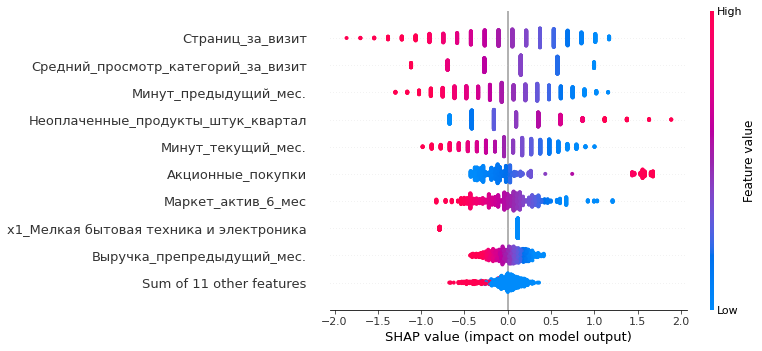

In [90]:
shap.plots.beeswarm(shap_values)

Негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0 (Покупательская активность оталась на прежнем уровне), а положительные справа — к классу 1 (Покупательская активность снизилась).

Исследуя SHAP‑значения на этой диаграмме, мы можем начать понимать природу взаимоотношений между признаками и спронозированной покупательской активностью.

С ростом просмотренных страниц за визит, SHAP-значения уменьшаются, т.е. покупательская активность остается на прежнем уровне.\
В случае увеличения значений признаков "Страниц за визит", "Средний просмотр категорий за визит", "Минут в предыдущем месяце", "Минут в текущем месяце", "Маркетинговая активность за 6 мес.", SHAP-значения уменьшаются, т.е. увеличение значений признаков также склоняет модель отнести покупательскую активность к типу 0, т.е. остается на прежнем уровне.\
В то время как, рост значений признака "Неоплаченные продукты штук квартал" "Акционные покупки" склоняют модель отнести покупательскую активность к типу 1, т.е. покупательская активность снизилась.

Можно сделать вывод, что интернет-магазину необходимо стараться заинтересовать покупателя больше времени проводить на сайте. Возможно предлагать похожие товары на те, что он ищет или сделать карточку товара наиболее привлекательной, а навигацию сайта более удобной. Снижение маркетинговой активности ведет к снижению покупательской активности. Интернет-магазину стоит вести работу с неоплаченными товарами в корзине клиента: напоминать о товарах; в случае сокращения количества товаров - присылать уведомление клиенту, что выбранный товар скоро закончится.

В то же время, на покупательскую активность не влияет как часто возникает ошибка сервера. Как оказалось, покупатели с пониманием относятся к таким проблемам. Длительность клиента с сайтом или какова популярная категория товара также не существена для модели.

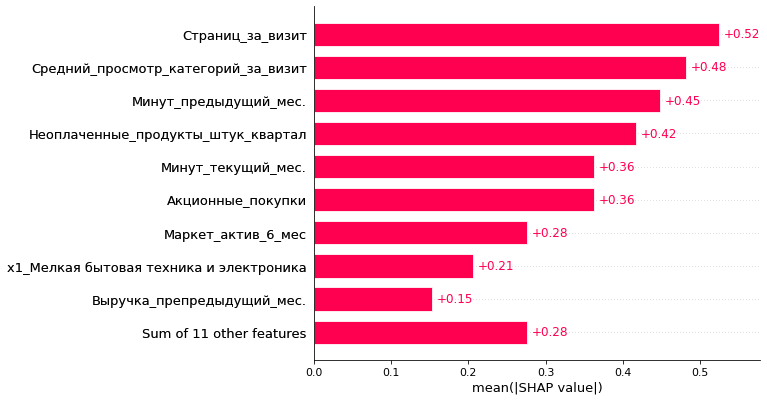

In [91]:
shap.plots.bar(shap_values) 

## Сегментация покупателей.

На основе полученной информации о вероятности снижения покупательской активности клиентов, а также Прибыльности клиентов для онлайн-магазина, выделим группу покупателей. Проанализируем полученную выборку и сформируем преждложения по работе с выбранным сегментом покупателей.

Объединим X_test, probabilities_one и money.

In [87]:
probabilities_one = pd.DataFrame(probabilities_one)
probabilities_one.head()

,0
0,0.013646
1,0.984809
2,0.113796
3,0.756905
4,0.522156


In [88]:
#Добавим индекс в таблицу:
X_test = X_test.reset_index()

#внесем в таблицу X_test данные о вероятности:
data = pd.concat([X_test, probabilities_one], axis=1)

#Переименуем столбец с вероятностью:
data = data.rename(columns = {0: 'Вероятность_снижения_покупательской_активнсоти'})
data.head()

,id,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий мес.,Выручка_препредыдущий_мес.,Выручка_текущий_мес.,Минут_предыдущий_мес.,Минут_текущий_мес.,Вероятность_снижения_покупательской_активнсоти
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,0.013646
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,0.984809
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,0.113796
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,0.756905
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,0.522156


In [89]:
#В data внесем информацию о прибыли:
data_money = data.merge(money, on='id', how='left')
data_money.head()

,id,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий мес.,Выручка_препредыдущий_мес.,Выручка_текущий_мес.,Минут_предыдущий_мес.,Минут_текущий_мес.,Вероятность_снижения_покупательской_активнсоти,Прибыль
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,0.013646,4.69
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,0.984809,2.75
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,0.113796,3.16
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,0.756905,3.74
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,0.522156,4.40


Построим диаграмму рассеивания для признаков "Прибыль" и "Вероятность снижения покупательской активности". Добавим третий признак "Акционные покупки", который будет влиять на цвет точек на графике.


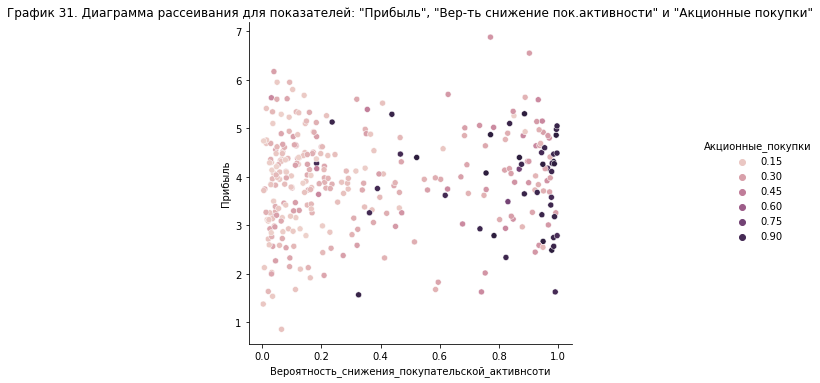

In [90]:
sns.relplot(data=data_money,
            kind='scatter',
            x='Вероятность_снижения_покупательской_активнсоти',
            y='Прибыль',
            hue='Акционные_покупки'
)
plt.title('График 31. Диаграмма рассеивания для показателей: "Прибыль", "Вер-ть снижение пок.активности" и "Акционные покупки"')
plt.show()

На диаграмме рассеивания можно выделить два кластера - снижение покупательской актвности от 0 до 0,6 (кластер 1) и от 0,6 до 1 (кластер 2). Стоит заметить, что доля акционных покупок выше у людей с высокой вероятностью снижения пок.активности.\
Проанализируем группу клиентов с максимальной долей покупок по акции (60-90%) и высокой вероятностью снижения покупательской активности (80-100%).

In [91]:
buyers = data_money.query('0.6 < Акционные_покупки < 1 and 0.8 < Вероятность_снижения_покупательской_активнсоти < 1')

buyers.head()

,id,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий мес.,Выручка_препредыдущий_мес.,Выручка_текущий_мес.,Минут_предыдущий_мес.,Минут_текущий_мес.,Вероятность_снижения_покупательской_активнсоти,Прибыль
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,0.984809,2.75
12,215375,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8,9,0.964505,4.18
18,215452,стандарт,да,3.8,4,756,0.90,Товары для детей,2,3,6,4,4045.0,4963.0,4206.2,11,10,0.944206,4.50
28,215362,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4,4314.0,4765.0,4447.9,13,13,0.830516,3.49
51,215587,премиум,да,4.6,4,800,0.93,Домашний текстиль,4,2,5,4,5551.0,4912.0,5549.7,7,7,0.929345,3.68


In [92]:
buyers.shape

(32, 19)

Под критерии попали 32 клиентов.

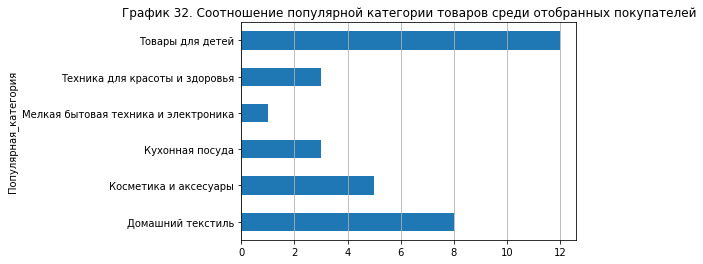

In [93]:
(
    buyers
    .pivot_table(index='Популярная_категория', values='id', aggfunc='count')
    .plot(kind='barh', legend=False)
)
plt.grid(axis='x')
plt.title('График 32. Соотношение популярной категории товаров среди отобранных покупателей');

Клиенты, отобранные для анализа, чаще всего покупают Товары для детей (37,5%) и Домашний текстиль (25%). Реже остальных категорий преобретается мелкая бытовая техника и электроника (3,1%)

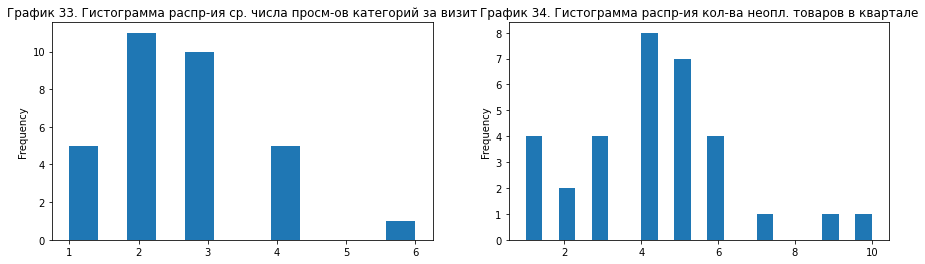

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
buyers['Средний_просмотр_категорий_за_визит'].plot(kind='hist', bins=12,  ax=axes[0])
axes[0].set_title("График 33. Гистограмма распр-ия ср. числа просм-ов категорий за визит")

buyers['Неоплаченные_продукты_штук_квартал'].plot(kind='hist', bins=21, ax=axes[1])
axes[1].set_title("График 34. Гистограмма распр-ия кол-ва неопл. товаров в квартале");

Клиенты чаще всего просматривают 2, 3 категории товаров и оставляю в корзине 4 или 5 неоплаченных товаров.

In [95]:
buyers.pivot_table(index='Тип_сервиса',\
                   values=['Выручка_препредыдущий_мес.', 'Выручка_предыдущий мес.', 'Выручка_текущий_мес.'],\
                  aggfunc='sum').sum()

Выручка_предыдущий мес.       163220.0
Выручка_препредыдущий_мес.    149213.0
Выручка_текущий_мес.          171701.2
dtype: float64

В текущем месяце покупатели потратили в интернет-магазине 171 тыс.руб., что на 5% больше, чем в предыдущем месяце.

In [96]:
round(buyers.pivot_table(index='Тип_сервиса',\
                   values=['Маркет_актив_6_мес', 'Маркет_актив_тек_мес'],\
                  aggfunc='mean'), 2)

,Маркет_актив_6_мес,Маркет_актив_тек_мес
Тип_сервиса,,
премиум,3.44,4.00
стандарт,3.33,3.89


За последние 6 месяцев маркетинговая активность в среднем составляла 3,38 штук. В текущем же месяце маркетинговая активность выросла, и клиенты премиум получили 4 маркетинговой коммуникации, а клиенты типа стандарт - 3,89 штук.

In [97]:
round(buyers.pivot_table(index='Тип_сервиса',\
                   values=['Минут_предыдущий_мес.', 'Минут_текущий_мес.'],\
                  aggfunc='mean'), 2)

,Минут_предыдущий_мес.,Минут_текущий_мес.
Тип_сервиса,,
премиум,9.57,9.50
стандарт,10.06,10.11


Количество времени, проведенного на сайте у отобранных клиентов существенно не изменилось в текущем месяце в сравнении с прошлым.

Клиенты с высокой вероятностью снижения покупательской активности и высокой долей акционных товаров чаще других товаров покупают товары для детей. К детским товарам можно отнести игрушки, детскую мебель, детский транспорт, еду, одежду и товары по уходу за ребенком. Таким образом, можно выделить 2 подкатегории - регулярные покупки, недорогостоящий товар и редкие покупки, дорогостоящий товар. В первом случае, покупатель чаще всего сравнивает цены на нескольких маркет-плейсах и выбирает более низкую. В случае с дорогостоящими товарами, помимо цены, покупатель обращает внимание на качество.\
Вторая самая популярная категория покупок - Домашний текстиль. Что также можно разделить на регулярные покупки недорогой вещи и редкие дорогостоящие покупки.\
Могу предложить следующие способы по удержанию покупательской активности:
- сохранять конкурентно-способные цены на детские товары и домашний текстиль;
- регулярно анализировать спрос на товары разных производителей и вносить корректировки в ассортимент магазина;
- работать с клиентами в сторону стимуляции завершить покупку, с целью уменьшения неоплаченных товаров в корзине покупателя;
- дополнить собираемую информацию: сохранять данные о каждой совершенной покупке. А именно, дата и время покупки, категория товара, производитель, стоимость товара, количество.

## Общий вывод

Итак, мы провели данное исследование с целью разработать модель, предсказывающию покупательскую активность клиента. Кроме того, проанализировать группу клиентов и предложить способы удержания посетителей сайта в качестве покупателя.\
Благодаря созданому пайплайну, который проанализировал несколько моделей и выбрал наилучшую, выяснили, что модель LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=RANDOM_STATE) дает наилучший результат. Метрика качества roc-auc на тренировочной выборке составила 0,898, площадь под roc-кривой на тестовой выборке - 0,918. Что является очень хорошим результатом.\
Распределение важности признаков показало, что в случае увеличения значений признаков "Средний просмотр категорий за визит", "Минут в предыдущем месяце", "Минут в текущем месяце", "Маркетинговая активность за 6 мес.", SHAP-значения уменьшаются, т.е. увеличение значений признаков также склоняет модель отнести покупательскую активность к типу 0, т.е. остается на прежнем уровне.\
В то время как, рост значений признака "Неоплаченные продукты штук квартал" склоняют модель отнести покупательскую активность к типу 1, т.е. покупательская активность снизилась.\
В то же время, на покупательскую активность не влияет как часто возникает ошибка сервера. Как оказалось, покупатели с пониманием относятся к таким проблемам. Длительность клиента с сайтом не существена для модели.

Для более полного анализа могу предложить заказчику расширить перечень собираемой информации о клиентах. Хранить не только сводную информацию о сумме покупок за месяц, и популярной категории, а хранить всю информацию о покупках: дата и время покупки, категория купленного товара и его сумма, применена ли к товару акция или нет. Каждое ли посещение сайта магазина заканчивается покупкой или нет.